# Exploratory Data Analysis

## Set up environment

In [90]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from fuzzywuzzy import process, fuzz

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/raw")

In [264]:
cwd = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [3]:
os.listdir(path)

['BX-NewBooksUsers.csv',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 'BX-NewBooks.csv']

## BX-Books

In [119]:
books = pd.read_csv(path + "/BX-Books.csv")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
3,0440234743,The Testament,John Grisham,1999,Dell
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume


### Null Values

No null values to deal with

In [5]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64

In [6]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Book-Publisher         object
dtype: object

### Year of publication
Year of Publication has max 2030 and min 0. Plot a histogram to see distribution for books published by year.
- 314 books published in year 0.
- 3 books published in year 2030 (not possible)

This imputation needs to be done after text processing on author, title and publisher.

In [7]:
books["Year-Of-Publication"].min(), books["Year-Of-Publication"].max()

(0, 2030)

<Axes: ylabel='Frequency'>

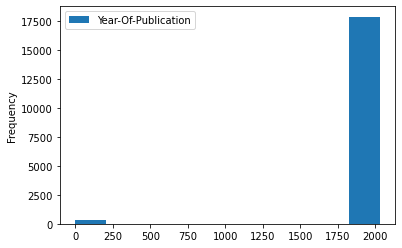

In [8]:
books.plot(kind = "hist", y = "Year-Of-Publication")

In [9]:
books.groupby("Year-Of-Publication")["ISBN"].count()

Year-Of-Publication
0        314
1920       2
1927       1
1929       1
1930       1
        ... 
2002    1750
2003    1530
2004     475
2005       3
2030       3
Name: ISBN, Length: 70, dtype: int64

In [295]:
books[books["Year-Of-Publication"] == 0].head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed
164,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc,barbara kingsolver,faber faber inc
195,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH,golding,fischer taschenbuch verlag gmbh
285,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri,p coelho,fabbri rcs libri
343,0590021117,Little House On the Prairie,Laura Ingall Wilder,0,Scholastic Inc,laura ingall wilder,scholastic inc
395,2070362388,Ravage,Rene Barjavel,0,Gallimard French,rene barjavel,gallimard french
441,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd,dick francis,michael joseph ltd
444,0349101779,The Wasp Factory,Iain Banks,0,Abacus,iain banks,abacus
488,0753804700,Reader,Bernhard Schlink,0,Phoenix Books,bernhard schlink,phoenix books
650,0140620338,Picture of Dorian Gray,Oscar Wilde,0,Penguin Putnam~mass,oscar wilde,penguin putnammass
661,000649840X,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk,frank mccourt,harpercollins uk


In [73]:
books[books["Book-Author"] == "barbara kingsolver"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
14,0060168013,pigs in heaven,barbara kingsolver,1993,harpercollins
164,0571197639,poisonwood bible edition uk,barbara kingsolver,0,faber faber inc
271,0060915544,the bean trees,barbara kingsolver,1989,perennial
272,0060917016,homeland and other stories,barbara kingsolver,1990,perennial
722,0060930535,the poisonwood bible: a novel,barbara kingsolver,1999,perennial
975,0060175400,the poisonwood bible,barbara kingsolver,1999,harpercollins
1200,0060922532,pigs in heaven,barbara kingsolver,1994,perennial
1743,0061097314,the bean trees,barbara kingsolver,1998,harpertorch
1749,0060504080,small wonder : essays,barbara kingsolver,2003,perennial
2101,0060199652,prodigal summer,barbara kingsolver,2000,harpercollins


In [72]:
books.iloc[164]

ISBN                                    0571197639
Book-Title             poisonwood bible edition uk
Book-Author                     barbara kingsolver
Year-Of-Publication                              0
Book-Publisher                     faber faber inc
Name: 164, dtype: object

In [11]:
books[books["Year-Of-Publication"] == 2030]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
11362,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
13687,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
15739,0870449842,Crossing America,National Geographic Society,2030,National Geographic


### ISBN 
Also noticed ISBN is a 10 digit number but some have and X at the end.
- ISBN is a 10 digit number before 2007. This dataset is fine for just 10.
- the only letter wich can be in an ISBN is an X to represent ten.

No duplicates on ISBN

In [12]:
books[~books["ISBN"].str.match(r"^(?=(?:\D*\d){9,10})|\d{9}X")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher


In [13]:
books[books["ISBN"].duplicated()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher


### Book-Author
Potential for Authors to be under different naming convention.
- For example Jack Du Brul vs Jack B. Du Brul
    - Do some text analysis in cleaning to give authors same name
- Also text is mix of upper/lowercase - case folding to lowercase.
- Look to see if there are any unknown names
    - unknown
    - Jack


In [296]:
author_dist = books.groupby("Book-Author")["ISBN"].count().sort_values(ascending=False).reset_index().rename(columns= {'ISBN':'Count'})

author_dist

,Book-Author-Processed,Count
0,stephen king,195
1,nora roberts,127
2,danielle steel,100
3,anne mccaffrey,88
4,piers anthony,75
...,...,...
5956,james runcie,1
5957,james s thayer,1
5958,james st james,1
5959,james tate,1


<Axes: xlabel='Count', ylabel='Book-Author-Processed'>

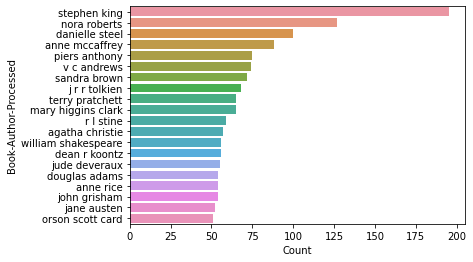

In [297]:
sns.barplot(author_dist.head(20), x = "Count", y = "Book-Author", orient = "h")

<Axes: xlabel='Count', ylabel='Book-Author-Processed'>

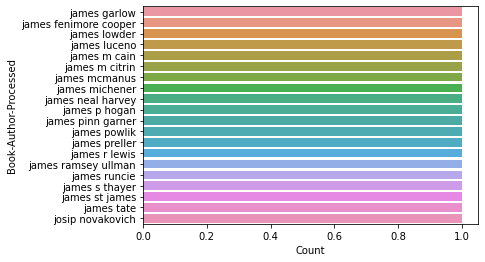

In [298]:
sns.barplot(author_dist.tail(20), x = "Count", y = "Book-Author", orient = "h")

##### Author text cleaning:
- case folding - lower.
- names like o'dell needed special consideration to odell not o dell as there are authors that have inital of middle name.
- consider co-authors with &.
- remove extra spaces.

In [299]:
# Define regex pattern to remove non-alphanumeric characters except '&'
pattern = r'[^a-zA-Z0-9& ]'

# Function to clean text based on regex pattern
def clean_text(text):
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [300]:
books["Book-Author"].unique().shape

(6452,)

In [301]:
books["Book-Author-Processed"] = books["Book-Author"].str.lower()

In [310]:
books["Book-Author-Processed"] = books["Book-Author-Processed"].str.replace("'", "")
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Author-Processed"] = books["Book-Author-Processed"].apply(clean_text).str.replace('  ', ' ').str.strip()

In [311]:
%%time
author_fuzzy_match = fuzzy_match_comparison("Author-Processed")
author_fuzzy_match.shape

5959
CPU times: user 52.4 s, sys: 964 ms, total: 53.4 s
Wall time: 55.6 s


(968, 3)

In [312]:
author_fuzzy_match.head()

,Author-Processed_sort,score_sort,match_sort
0,gabriel garacia marquez,98,gabriel garcia marquez
1,jean christophe grang,98,jean christophe grange
2,bathroom reader institute,98,bathroom readers institute
3,friedrich duerenmatt,98,friedrich duerrenmatt
4,vonda n mcintryre,97,vonda n mcintyre


In [313]:
author_fuzzy_match.tail()

,Author-Processed_sort,score_sort,match_sort
963,joan anderson,80,ken anderson
964,carol burnett,80,mark burnett
965,joe connelly,80,john connolly
966,edward ball,80,edward bellamy
967,john mcphee,80,john peel


In [315]:
author_fuzzy_match.to_csv(cwd + "/data/cleaned/author_fuzzy_match.csv")

### Fuzzy matching strings
- Set up function for different columns
- at beginning of processing case fold
    - books["Book-Author"] = books["Book-Author"].str.lower()
- get rid of .,!:- etc.
- some books have similar title. For example:
    - "the beach" vs. "the breach" - similarity = 0.95 but are different authors.
    - "the far side gallery 4" vs. "the far side gallery 5" - similarity = 0.95 but different version in series.
 
- Books will need to be processed. tf-idf? for similar titles?

In [316]:
books["Book-Title"] = books["Book-Title"].str.lower()

In [51]:
def fuzzy_match_comparison(col):
    
    unique = books[f"Book-{col}"].unique()
    print(len(unique))
    
    score_sort = [(x,) + i
             for x in unique
             for i in process.extract(x, unique, scorer=fuzz.ratio)] 
    
    similarity_sort = pd.DataFrame(score_sort, columns=[f'{col}_sort','match_sort','score_sort'])
    similarity_sort[f'sorted_{col}_sort'] = np.minimum(similarity_sort[f'{col}_sort'], similarity_sort['match_sort'])

    high_score_sort = \
    similarity_sort[(similarity_sort['score_sort'] >= 80) & \
                    (similarity_sort[f'{col}_sort'] !=  similarity_sort['match_sort']) & \
                    (similarity_sort[f'sorted_{col}_sort'] != similarity_sort['match_sort'])] 
    high_score_sort = high_score_sort.drop(f'sorted_{col}_sort',axis=1).copy()

    high_score_sort = high_score_sort.groupby([f'{col}_sort','score_sort']).agg(
                        {'match_sort': ', '.join}).sort_values(
                        ['score_sort'], ascending=False).reset_index()

    return high_score_sort

In [42]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,0002005018,Clara Callan,richard bruce wright,2001,HarperFlamingo Canada
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,gina bari kolata,1999,Farrar Straus Giroux
2,0399135782,The Kitchen God's Wife,amy tan,1991,Putnam Pub Group
3,0440234743,The Testament,john grisham,1999,Dell
4,0452264464,Beloved (Plume Contemporary Fiction),toni morrison,1994,Plume


In [52]:
%%time
title_fuzzy_match = fuzzy_match_comparison("Title")
title_fuzzy_match

15976
CPU times: user 11min 55s, sys: 14.6 s, total: 12min 10s
Wall time: 12min 54s


,Title_sort,score_sort,match_sort
0,all american girl,100,all-american girl
1,house of god,100,house of god.
2,die entdeckung der langsamkeit,100,die entdeckung der langsamkeit.
3,sybil,100,sybil.
4,small world,100,small world.
...,...,...,...
3302,the heretic's apprentice: the sixteenth chroni...,80,the potter's field: the seventeenth chronicle ...
3303,the hiding place: a novel,80,the living : a novel
3304,fishbowl (red dress ink (paperback)),80,out of the blue (red dress ink (paperback))
3305,first cut,80,first truth


In [76]:
title_fuzzy_match[title_fuzzy_match["score_sort"] <= 95].head()

,Title_sort,score_sort,match_sort
287,the wind in the willows (wordsworth collection),95,wind in the willows (wordsworth collection)
288,false prophet: a peter decker/rina lazarus mys...,95,false prophet: a peter decker/rina lazarus nov...
289,people of the earth (the first north americans...,95,people of the sea (the first north americans s...
290,flash point,95,flashpoint
291,a stranger is watching,95,stranger is watching
292,rabbit run,95,"rabbit, run"
293,siddharta,95,siddhartha
294,weave world,95,weaveworld
295,"godel, escher, bach: an eternal golden braid",95,"gãâ¶del, escher, bach: an eternal golden braid"
296,dark angel,95,darkangel


In [86]:
books[books["Book-Title"].isin(["prince charming", "princess charming"])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
6209,0671870963,prince charming,julie garwood,1995,pocket
12676,1575662612,princess charming,jane heller,1997,kensington publishing corporation
17351,0671870955,prince charming,julie garwood,1994,atria


In [65]:
%%time
publisher_fuzzy_match = fuzzy_match_comparison("Publisher")
publisher_fuzzy_match

1330
CPU times: user 2.97 s, sys: 145 ms, total: 3.12 s
Wall time: 3.5 s


,Publisher_sort,score_sort,match_sort
0,penguin books australia ltd,100,penguin books australia ltd.
1,scholastic inc,100,scholastic inc.
2,random house trade,100,random house~trade
3,droemersche verlagsanstalt th. knaur nachf. gm...,99,"droemersche verlagsanstalt th. knaur nachf., g..."
4,wilhelm goldmann verlag gmbh,98,"wilhelm goldmann verlag, gmbh"
...,...,...,...
411,living books,80,vintage books
412,livre de poche,80,livre de poche french
413,modern publishing,80,workman publishing
414,mondadori (it),80,mondadori italian


### Book-Title
- Books can be published by other publisher
- Potential for Book-Title to be similar
- Duplicates on Book-Publisher and Book-Title
    - No concern 

<Axes: xlabel='Count', ylabel='Book-Title'>

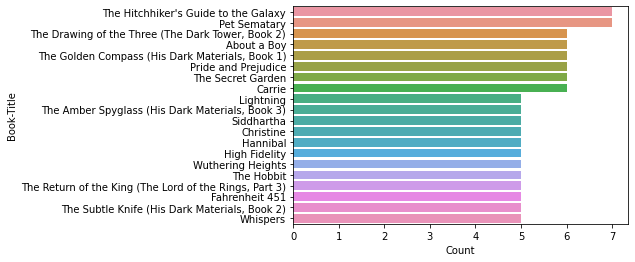

In [117]:
books_title = books.groupby(["Book-Title"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

duplicate_books = books_title[books_title["Count"] > 1]

sns.barplot(duplicate_books.head(20), x = "Count", y = "Book-Title", orient = "h")

In [119]:
books[books["Book-Title"].isin(duplicate_books["Book-Title"])].sort_values(by = "Book-Title").head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
4643,0451168089,'Salem's Lot,Stephen King,1990,Signet Book
16688,0385007515,'Salem's Lot,Stephen King,1993,Doubleday Books
10276,0717284832,101 Dalmatians,Walt Disney,1995,Stoddart+publishing
337,0307001164,101 Dalmatians,Justine Korman,1996,Golden Books Publishing Company
14503,207036822X,1984,George Orwell,0,Gallimard French
3842,0451519841,1984,George Orwell,1980,New Amer Library
5470,0452262933,1984,George Orwell,1983,Plume Books
1117,0451524934,1984,George Orwell,1990,Signet Book
991,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision
2044,0316666009,1st to Die: A Novel,James Patterson,2001,Little Brown and Company


In [121]:
books_tp = books.groupby(["Book-Title", "Book-Publisher"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

In [131]:
books[books["Book-Title"].isin(books_tp["Book-Title"].head(5))].sort_values("Book-Title")

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
4650,1591820073,Chobits (Chobits),Clamp,2003,TokyoPop
4649,1591821533,Chobits (Chobits),Clamp,2003,TokyoPop
4648,1591822572,Chobits (Chobits),Clamp,2003,TokyoPop
4647,1591822580,Chobits (Chobits),Clamp,2003,TokyoPop
1528,0812533550,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books
499,0312853238,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1992,Tor Books
1020,0765342294,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,2002,Starscape Books
1168,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994,Tor Books
6336,0451150244,Pet Sematary,Stephen King,1984,Signet Book
9712,0451139755,Pet Sematary,Stephen King,1985,New Amer Library


#### Title text cleaning:
Will try to get information out of title using text processing techniques - BoW, vectorise for distances. Not much text to go off though.

In [333]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [334]:
books["Book-Title"].unique().shape

(15976,)

In [472]:
books[books["Book-Title"].str.contains("1984")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info
1117,0451524934,1984,George Orwell,1990,Signet Book,george orwell,signet book,1984,title 1984 author george orwell year 1990 publ...
2696,0679417397,1984 (everyman's library),GEORGE ORWELL,1992,Everyman's Library,george orwell,everyman library,1984 everyman library,title 1984 everyman library author george orwe...
3842,0451519841,1984,George Orwell,1980,New Amer Library,george orwell,new amer library,1984,title 1984 author george orwell year 1980 publ...
4039,0881030368,1984 (signet classics (paperback)),George Orwell,1999,Sagebrush Bound,george orwell,sagebrush bound,1984 signet classic paperback,title 1984 signet classic paperback author geo...
5470,0452262933,1984,George Orwell,1983,Plume Books,george orwell,plume book,1984,title 1984 author george orwell year 1983 publ...
14503,207036822X,1984,George Orwell,0,Gallimard French,george orwell,gallimard french,1984,title 1984 author george orwell year 0 publish...
16492,8423309835,1984 (spanish language edition),George Orwell,1984,Destino Ediciones,george orwell,destino ediciones,1984 spanish language edition,title 1984 spanish language edition author geo...
17098,0393310752,the fact of a doorframe: poems selected and ne...,Adrienne Rich,1994,W W Norton & Co,adrienne rich,w w norton co,fact doorframe poem selected new 1950 1984,title fact doorframe poem selected new 1950 19...


In [336]:
books["Book-Title-Processed"] = books["Book-Title"].str.lower()

In [337]:
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Title-Processed"] = books["Book-Author-Processed"].str.replace(r'[^a-zA-Z]', ' ', regex = True).str.replace('  ', ' ')

In [412]:
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return the processed text as a string
    return " ".join(tokens)

def preprocess_dataframe(df, column_name):
    df[f"{column_name}-Processed"] = df[column_name].apply(preprocess_text)
    return df

In [421]:
books = preprocess_dataframe(books, "Book-Publisher")
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed
0,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan
1,0374157065,flu: the story of the great influenza pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,gina bari kolata,farrar straus giroux,flu story great influenza pandemic 1918 search...
2,0399135782,the kitchen god's wife,Amy Tan,1991,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife
3,0440234743,the testament,John Grisham,1999,Dell,john grisham,dell,testament
4,0452264464,beloved (plume contemporary fiction),Toni Morrison,1994,Plume,toni morrison,plume,beloved plume contemporary fiction
...,...,...,...,...,...,...,...,...
18180,0375411615,"love, etc.",Julian Barnes,2001,Alfred A. Knopf,julian barnes,alfred knopf,love etc
18181,0836227751,the wit and whimsy of mary engelbreit,Mary Engelbreit,1997,Andrews McMeel Publishing,mary engelbreit,andrew mcmeel publishing,wit whimsy mary engelbreit
18182,8433966634,los detectives salvajes,Roberto Bolano,2003,Anagrama,roberto bolano,anagrama,los detective salvajes
18183,0330353349,the ice house (tv tie-in edition),Minette Walters,1997,McClelland & Stewart,minette walter,mcclelland stewart,ice house tv tie edition


In [460]:
books["Book-Info"] = "title " + books["Book-Title-Processed"] + " author " + books["Book-Author-Processed"] + " year " \
+ books["Year-Of-Publication"].astype(str) + " publisher " + books["Book-Publisher-Processed"]

In [461]:
# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books['Book-Info'])

In [462]:
cosine_sim =  cosine_similarity(tfidf_matrix, tfidf_matrix)

In [463]:
indices = pd.Series(books['Book-Title'])
indices[:5]

0                                         clara callan
1    flu: the story of the great influenza pandemic...
2                               the kitchen god's wife
3                                        the testament
4                 beloved (plume contemporary fiction)
Name: Book-Title, dtype: object

In [464]:
def recommend(title, cosine_sim = cosine_sim):
    if title not in indices.values:
        return "Title not found in the database."
    recommended_books = []
    idx = indices[indices == title].index[0]   # to get the index of book name matching the input book_name
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_10_indices = list(score_series.iloc[1:11].index)   # to get the indices of top 10 most similar books
    # [1:11] to exclude 0 (index 0 is the input book itself)
    
    for i, x in zip(top_10_indices, score_series.iloc[1:11]):   # to append the titles of top 10 similar booksto the recommended_books list
        recommended_books.append([list(books['Book-Info'])[i], round(x, 2)])
        
    return recommended_books

In [469]:
recommend("the kitchen god's wife")

[['title kitchen god wife author amy tan year 1992 publisher ivy book', 0.79],
 ['title kitchen god wife vintage contemporary author amy tan year 1993 publisher vintage book usa',
  0.65],
 ['title hundred secret sens author amy tan year 1995 publisher putnam pub group',
  0.52],
 ['title bonesetter daughter author amy tan year 2001 publisher putnam publishing group',
  0.41],
 ['title joy luck club author amy tan year 1991 publisher vintage', 0.4],
 ['title joy luck club author amy tan year 1989 publisher putnam publishing group',
  0.39],
 ['title bonesetter daughter author amy tan year 2002 publisher ballantine book',
  0.35],
 ['title hundred secret sens author amy tan year 1996 publisher ivy book',
  0.34],
 ['title hundred secret sens author amy tan year 1998 publisher vintage book usa',
  0.34],
 ['title joy luck club vintage contemporary author amy tan year 1991 publisher vintage book usa',
  0.34]]

In [444]:
books[books["Book-Title-Processed"].isin(['clara callan novel','clara callan'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info
0,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callanrichard bruce wright2001harperflam...
16235,0060506067,clara callan : a novel,Richard B. Wright,2002,HarperCollins,richard b wright,harpercollins,clara callan novel,clara callan novelrichard b wright2002harperco...


In [411]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed
0,0002005018,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan,harperflamingo canada,clara callan
1,0374157065,flu: the story of the great influenza pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,flu the story of the great influenza pandemic ...,farrar straus giroux,flu story great influenza pandemic search viru...
2,0399135782,the kitchen god's wife,Amy Tan,1991,Putnam Pub Group,the kitchen god s wife,putnam pub group,kitchen god wife
3,0440234743,the testament,John Grisham,1999,Dell,the testament,dell,testament
4,0452264464,beloved (plume contemporary fiction),Toni Morrison,1994,Plume,beloved plume contemporary fiction,plume,beloved plume contemporary fiction


In [257]:
# Define regex pattern to remove non-alphanumeric characters except '&'
pattern = r'[^a-zA-Z0-9& ]'

# Function to clean text based on regex pattern
def clean_text(text):
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

### Book-Publisher
String Fuzzy match for all text data 

<Axes: xlabel='Count', ylabel='Book-Publisher'>

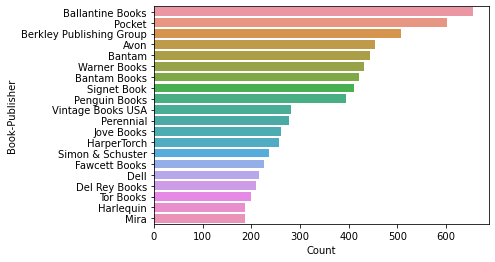

In [293]:
books_publisher = books.groupby(["Book-Publisher"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

sns.barplot(books_publisher.head(20), x = "Count", y = "Book-Publisher", orient = "h")

<Axes: xlabel='Count', ylabel='Book-Publisher'>

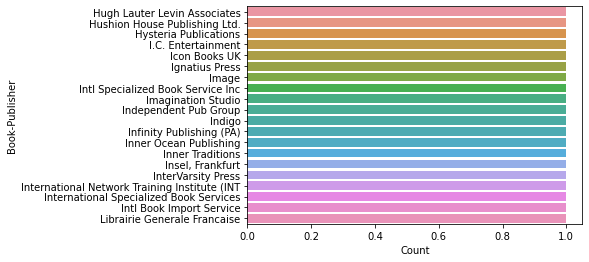

In [294]:
sns.barplot(books_publisher.tail(20), x = "Count", y = "Book-Publisher", orient = "h")

##### Publisher text cleaning:

In [255]:
books["Book-Publisher"].unique().shape

(1344,)

In [256]:
books["Book-Publisher-Processed"] = books["Book-Publisher"].str.lower()

In [257]:
# Define regex pattern to remove non-alphanumeric characters except '&'
pattern = r'[^a-zA-Z0-9& ]'

# Function to clean text based on regex pattern
def clean_text(text):
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [258]:
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Publisher-Processed"] = books["Book-Publisher-Processed"].apply(clean_text).str.strip()
# books["Book-Publisher-Processed"] = books["Book-Publisher-Processed"].str.strip()

In [260]:
%%time
publisher_fuzzy_match = fuzzy_match_comparison("Publisher-Processed")
publisher_fuzzy_match.shape

1320
CPU times: user 2.72 s, sys: 39.3 ms, total: 2.76 s
Wall time: 2.84 s


(411, 3)

In [268]:
publisher_fuzzy_match.head()

,Publisher-Processed_sort,score_sort,match_sort
0,ullstein buchverlage gmbh & co kg ullstein tas,98,ullstein buchverlage gmbh & cokg ullstein tasc
1,harpercollins publisher,98,harpercollins publishers
2,harper collins publishers,98,harpercollins publishers
3,harper collins canada,98,harpercollins canada
4,harper sanfrancisco,97,harpersanfrancisco


In [243]:
publisher_fuzzy_match.tail()

,Publisher-Processed_sort,score_sort,match_sort
406,knopf books for young readers,80,random house books for young readers
407,abacus,80,abacus uk
408,kensington publishing corporation,80,new directions publishing corporation
409,jove books,80,vega books
410,zebra books,80,zed books


In [290]:
publisher_fuzzy_match.to_csv(cwd + "/data/cleaned/publisher_fuzzy_match.csv")

## BX-Users

In [54]:
users = pd.read_csv(path + "/BX-Users.csv")
users.columns

Index(['User-ID', 'User-City', 'User-State', 'User-Country', 'User-Age'], dtype='object')

In [55]:
users.shape

(48299, 5)

In [56]:
users.dtypes

User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object

## Initial Look 
Null values to deal with:
- User-City: 61
- User-Country: 669
- User-Age: 18952 (39.2% of users)
- User-State: 666

Can see that User-State has empty strings:' '.

strings have white space at beginning - strip these.

Some values in columns have trailing " to remove.

deal with n/a in each columns

In [148]:
users.isna().sum()

User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64

In [174]:
users[users["User-City"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,"canada""",26
616,3569,NaN,n/a,"usa""",NaN
731,4221,NaN,connecticut,"usa""",NaN
1904,11676,NaN,n/a,"n/a""",NaN
2107,12966,NaN,n/a,"singapore""",28


In [168]:
users[users["User-ID"] == 277124]["User-State"] == ' '

47963    True
Name: User-State, dtype: bool

In [175]:
users[users["User-State"] == " "].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,,NaN,"14"""
133,777,portland,,NaN,"13"""
160,929,king of prussia,,NaN,"36"""
196,1118,cleveland,,"usa""",NaN
198,1131,berkeley,,NaN,"22"""


In [172]:
users[users["User-State"] == " "].shape

(666, 5)

In [176]:
users[users["User-Country"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,,NaN,"14"""
133,777,portland,,NaN,"13"""
160,929,king of prussia,,NaN,"36"""
198,1131,berkeley,,NaN,"22"""
284,1589,clio,michigan,NaN,"50"""


In [177]:
users[users["User-Age"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",NaN
1,9,germantown,tennessee,"usa""",NaN
2,16,albuquerque,new mexico,"usa""",NaN
3,17,chesapeake,virginia,"usa""",NaN
5,26,bellevue,washington,"usa""",NaN


### Remove trailing ":

In [178]:
users["User-Country"].str.rstrip('"')

0            canada
1               usa
2               usa
3               usa
4               NaN
            ...    
48294        canada
48295        canada
48296           usa
48297     australia
48298           usa
Name: User-Country, Length: 48299, dtype: object

In [179]:
users["User-Country"]

0            canada"
1               usa"
2               usa"
3               usa"
4                NaN
            ...     
48294        canada"
48295        canada"
48296           usa"
48297     australia"
48298           usa"
Name: User-Country, Length: 48299, dtype: object

In [180]:
users["User-City"] = users["User-City"].str.rstrip('"')
users["User-State"] = users["User-State"].str.rstrip('"')
users["User-Country"] = users["User-Country"].str.rstrip('"')
users["User-Age"] = users["User-Age"].str.rstrip('"')

In [181]:
users.head(20)

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,NaN
1,9,germantown,tennessee,usa,NaN
2,16,albuquerque,new mexico,usa,NaN
3,17,chesapeake,virginia,usa,NaN
4,19,weston,,NaN,14
5,26,bellevue,washington,usa,NaN
6,32,portland,oregon,usa,NaN
7,39,cary,north carolina,usa,NaN
8,42,appleton,wisconsin,usa,17
9,44,black mountain,north carolina,usa,51


## User-ID
No duplicates

In [184]:
users[users["User-ID"].duplicated()]

,User-ID,User-City,User-State,User-Country,User-Age


## User-City

<Axes: xlabel='Count', ylabel='User-City'>

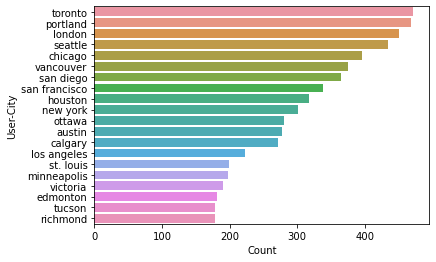

In [188]:
users_city = users.groupby(["User-City"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_city.head(20), x = "Count", y = "User-City", orient = "h")

<Axes: xlabel='Count', ylabel='User-City'>

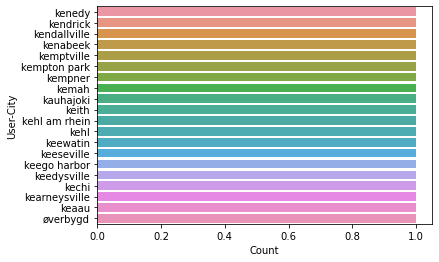

In [189]:
sns.barplot(users_city.tail(20), x = "Count", y = "User-City", orient = "h")

## User-State

<Axes: xlabel='Count', ylabel='User-State'>

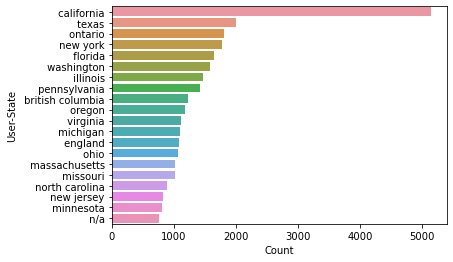

In [206]:
users_state = users.groupby(["User-State"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_state.head(20), x = "Count", y = "User-State", orient = "h")

<Axes: xlabel='Count', ylabel='User-State'>

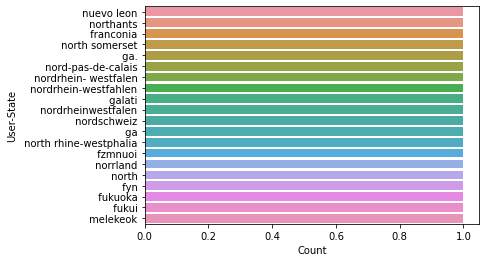

In [207]:
sns.barplot(users_state.tail(20), x = "Count", y = "User-State", orient = "h")

## User-Country

<Axes: xlabel='Count', ylabel='User-Country'>

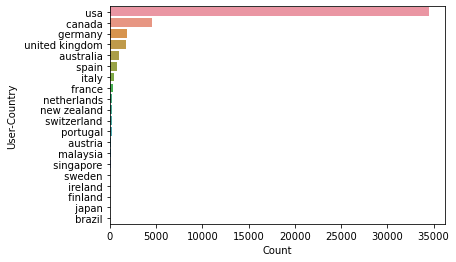

In [208]:
users_country = users.groupby(["User-Country"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_city.head(20), x = "Count", y = "User-Country", orient = "h")

<Axes: xlabel='Count', ylabel='User-Country'>

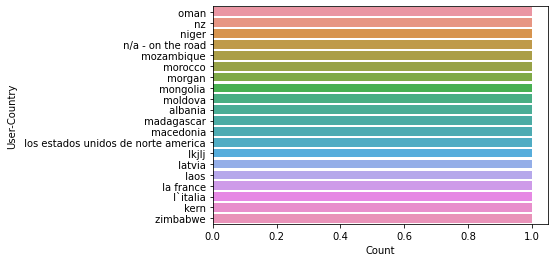

In [212]:
sns.barplot(users_country.tail(20), x = "Count", y = "User-Country", orient = "h")

## User-Age
- Ages that are NaN set to -1 and removed for analysis.
- Impute mean, based on other features.
- Ages above ~90 outliers.
- Average age is 36.2.

<Axes: xlabel='Count', ylabel='User-Age'>

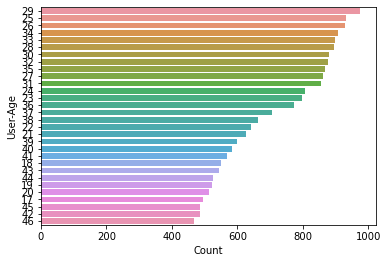

In [215]:
users_age = users.groupby(["User-Age"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_age.head(30), x = "Count", y = "User-Age", orient = "h")

<Axes: xlabel='Count', ylabel='User-Age'>

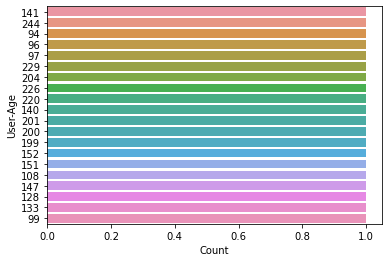

In [218]:
sns.barplot(users_age.tail(20), x = "Count", y = "User-Age", orient = "h")

In [241]:
users["User-Age"] = users["User-Age"].fillna(-1).astype(int)

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='User-Age', ylabel='Count'>

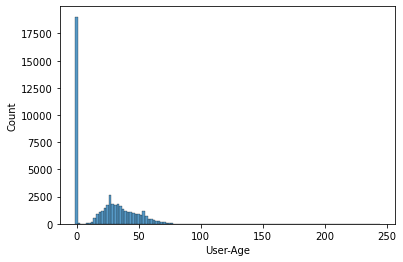

In [242]:
sns.histplot(users, x = "User-Age")

In [244]:
users_age = users[users["User-Age"] != -1]

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='User-Age', ylabel='Count'>

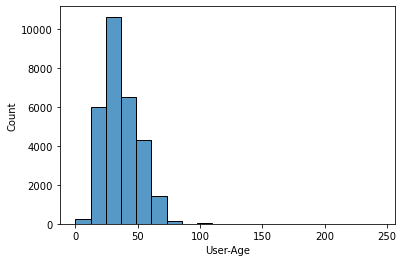

In [250]:
sns.histplot(users_age, x = "User-Age", bins = 20)

In [246]:
users_age.describe()

,User-ID,User-Age
count,29347.000000,29347.000000
mean,139454.265751,36.204178
std,80448.399162,14.681020
min,19.000000,0.000000
25%,69601.000000,26.000000
50%,138514.000000,34.000000
75%,209461.000000,45.000000
max,278852.000000,244.000000


<Axes: xlabel='User-Age'>

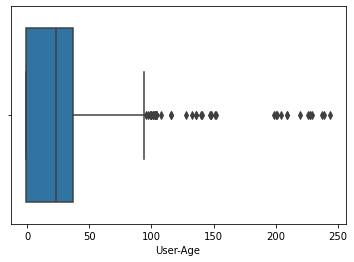

In [247]:
sns.boxplot(users, x = "User-Age")

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='User-Age', ylabel='Count'>

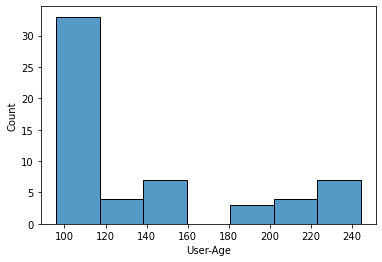

In [248]:
sns.histplot(users[users["User-Age"] > 95], x = "User-Age")

In [252]:
users[users["User-Age"] > 95].head(10)

,User-ID,User-City,User-State,User-Country,User-Age
591,3437,honolulu,hawaii,usa,103
1483,8782,calgary,alberta,canada,239
2056,12692,jacksonville,florida,usa,151
2158,13273,harrisburg,pennsylvania,usa,201
2233,13801,burlington,ontario,canada,104
3368,20857,stuttgart,baden-wuerttemberg,germany,244
4319,26083,leipzig,sachsen,NaN,104
4682,28091,fort collins,colorado,usa,128
5145,30590,cambridge,cambridgeshire,united kingdom,141
5595,32642,boston,massachusetts,usa,103


## BX-ratings
No Nulls



In [291]:
ratings = pd.read_csv(path + "/BX-Ratings.csv")
ratings.columns

ratings["User-ID"] = ratings["User-ID"].astype(str)

In [258]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [260]:
ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

In [257]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [262]:
ratings.describe()

,User-ID,Book-Rating
count,204164.000000,204164.000000
mean,137166.622181,7.719676
std,80827.995079,1.791132
min,8.000000,1.000000
25%,68128.000000,7.000000
50%,135351.000000,8.000000
75%,208406.000000,9.000000
max,278854.000000,10.000000


/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Book-Rating', ylabel='Count'>

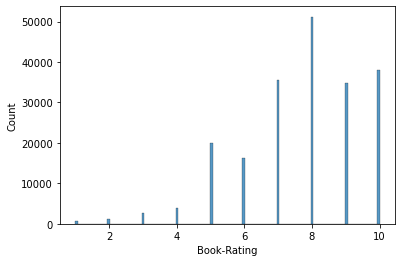

In [268]:
sns.histplot(ratings, x = "Book-Rating")

<Axes: xlabel='Book-Rating'>

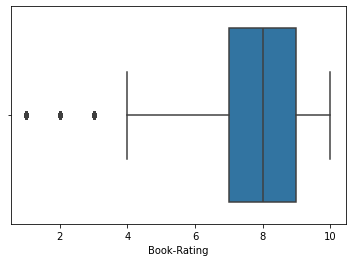

In [269]:
sns.boxplot(ratings, x = "Book-Rating")

In [276]:
ratings.groupby("User-ID")["ISBN"].count().reset_index().rename(columns = {"ISBN":"Count"}).sort_values("Count")

,User-ID,Count
0,8,1
23752,136628,1
23751,136625,1
23750,136619,1
23749,136618,1
...,...,...
19734,114368,432
2728,16795,516
26736,153662,603
17006,98391,1174


<Axes: xlabel='Count', ylabel='User-ID'>

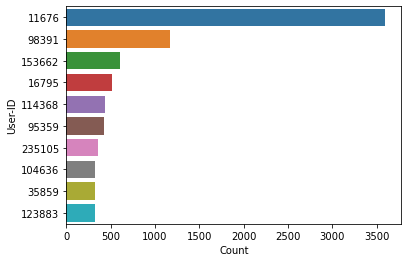

In [295]:
ratings_users = ratings.groupby(["User-ID"])["ISBN"].count() \
    .reset_index().rename(columns= {'ISBN':'Count'}).sort_values(by = "Count",ascending = False)

sns.barplot(ratings_users.head(10), x = "Count", y = "User-ID", orient = "h")

<Axes: xlabel='Count', ylabel='User-ID'>

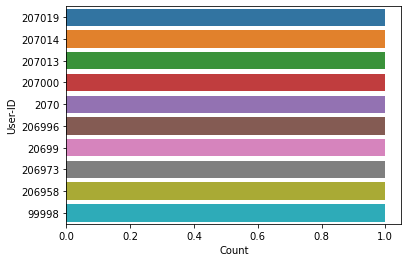

In [296]:
sns.barplot(ratings_users.tail(10), x = "Count", y = "User-ID", orient = "h")

In [300]:
ratings_user_average = ratings.groupby(["User-ID"])["Book-Rating"].mean() \
     .reset_index().rename(columns= {'Book-Rating':'Average'}).sort_values(by = "Average",ascending = False)
ratings_user_average.head(20)

,User-ID,Average
21853,21468,10.0
5720,12972,10.0
45594,85549,10.0
45593,85540,10.0
25633,234016,10.0
25636,234038,10.0
25652,234134,10.0
5704,129641,10.0
25661,234180,10.0
45587,85515,10.0


### Merge ratings with BX-Books to see titles

In [335]:
ratings = ratings.merge(books)

In [337]:
ratings_book = ratings.groupby(["Book-Title"]).agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count")).reset_index()
ratings_book

,Book-Title,mean,count
0,Earth Prayers From around the World: 365 Pray...,7.142857,7
1,Good Wives: Image and Reality in the Lives of...,8.000000,4
2,Murder of a Sleeping Beauty (Scumble River My...,7.000000,5
3,"Q-Space (Star Trek The Next Generation, Book 47)",8.250000,4
4,!Yo!,8.142857,7
...,...,...,...
16130,one hundred years of solitude,7.500000,8
16131,stardust,8.115385,26
16132,together by christmas,7.000000,4
16133,why I'm like this : True Stories,7.833333,6


In [339]:
ratings_author = ratings.groupby(["Book-Author"]).agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count")).reset_index()
ratings_author

,Book-Author,mean,count
0,A Lobo Antunes,6.500000,4
1,A. A. Attanasio,7.250000,4
2,A. A. Milne,8.045455,22
3,A. C. Bhaktivedanta Swami Prabhupada et al.,7.777778,9
4,A. C. Crispin,6.500000,4
...,...,...,...
6447,Zz Packer,8.250000,4
6448,"\Pickles\""""",8.500000,4
6449,bell hooks,9.000000,5
6450,stephen R Donaldson,8.400000,5


In [342]:
ratings_stats = ratings.groupby(["Book-Title", "Book-Author", "Book-Publisher"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count")).reset_index()

In [343]:
ratings_stats

,Book-Title,Book-Author,Book-Publisher,mean,count
0,Earth Prayers From around the World: 365 Pray...,Elizabeth Roberts,HarperSanFrancisco,7.142857,7
1,Good Wives: Image and Reality in the Lives of...,Laurel Thatcher Ulrich,Vintage Books USA,8.000000,4
2,Murder of a Sleeping Beauty (Scumble River My...,Denise Swanson,Signet Book,7.000000,5
3,"Q-Space (Star Trek The Next Generation, Book 47)",Greg Cox,Star Trek,8.250000,4
4,!Yo!,Julia Alvarez,Plume Books,8.142857,7
...,...,...,...,...,...
17841,one hundred years of solitude,Gabriel Garcia Marquez,Harpercollins Publisher,7.500000,8
17842,stardust,Neil Gaiman,Perennial,8.115385,26
17843,together by christmas,C.J. Carmichael,Harlequin,7.000000,4
17844,why I'm like this : True Stories,Cynthia Kaplan,Perennial,7.833333,6


<Axes: xlabel='count', ylabel='mean'>

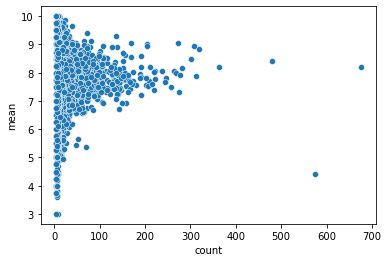

In [344]:
sns.scatterplot(ratings_stats, x = "count", y = "mean")

### Merge ratings with BX-Users to see more info

In [348]:
users["User-ID"] = users["User-ID"].astype(str)

In [357]:
ratings = ratings.merge(users)
# remove -1 ages for now
# impute later
ratings = ratings[ratings["User-Age"] != -1]

ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,User-City,User-State,User-Country,User-Age
0,276754,0684867621,8,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999,Scribner,alberta beach,alberta,canada,19
1,276755,0451166892,5,The Pillars of the Earth,Ken Follett,1996,Signet Book,frankfurt am main,hessen,germany,32
2,276762,0380711524,5,See Jane Run,Joy Fielding,1992,Avon,duisburg,nordrhein-westfalen,germany,25
3,276796,0330332775,5,Bridget Jones's Diary,Helen Fielding,1997,Picador (UK),manchester,england,united kingdom,21
4,276798,3548603203,6,Artemis Fowl.,Eoin Colfer,2003,Ullstein TB-Vlg,mannheim,baden-wuerttemberg,germany,31


<Axes: xlabel='count', ylabel='mean'>

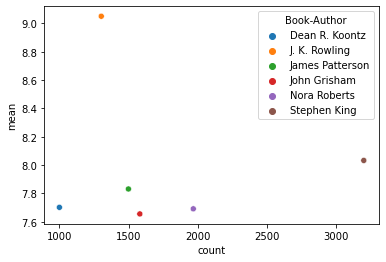

In [378]:
ratings_avg_age = ratings.groupby(["Book-Author"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count"), average_age = ("User-Age", "mean")) \
    .reset_index()
sns.scatterplot(ratings_avg_age[ratings_avg_age["count"] > 1000], x = "count", y = "mean", hue = "Book-Author")

<Axes: xlabel='count', ylabel='average_age'>

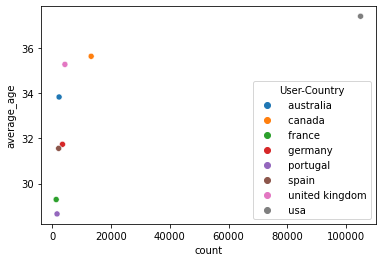

In [371]:
ratings_avg_age = ratings.groupby(["User-Country"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count"), average_age = ("User-Age", "mean")) \
    .reset_index()
sns.scatterplot(ratings_avg_age[ratings_avg_age["count"] > 1000], x = "count", y = "average_age", hue = "User-Country")

' portugal'

In [393]:
author_country[author_country["User-Country"].isin([" australia", " usa", " canada", " france"])]

,Book-Author,User-Country,mean,count,average_age
1,A. A. Attanasio,canada,8.000000,1,29.000000
3,A. A. Milne,usa,8.142857,14,38.285714
4,A. C. Bhaktivedanta Swami Prabhupada et al.,australia,8.000000,3,25.666667
7,A. C. Bhaktivedanta Swami Prabhupada et al.,usa,6.000000,2,42.000000
8,A. C. Crispin,canada,7.000000,1,34.000000
...,...,...,...,...,...
17232,Zz Packer,usa,8.250000,4,51.500000
17234,"\Pickles\""""",usa,8.333333,3,41.666667
17235,bell hooks,usa,9.000000,2,30.000000
17236,stephen R Donaldson,canada,8.000000,1,28.000000


In [401]:
author_country = ratings.groupby(["Book-Author", "User-Country"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count"), average_age = ("User-Age", "mean")) \
    .reset_index()
author_country = author_country = author_country[author_country["User-Country"].isin([" usa", " france", " australia"])]
author_country.head()

,Book-Author,User-Country,mean,count,average_age
3,A. A. Milne,usa,8.142857,14,38.285714
4,A. C. Bhaktivedanta Swami Prabhupada et al.,australia,8.000000,3,25.666667
7,A. C. Bhaktivedanta Swami Prabhupada et al.,usa,6.000000,2,42.000000
9,A. C. Crispin,usa,7.000000,2,45.500000
16,A. C. H. Smith,usa,6.000000,1,27.000000


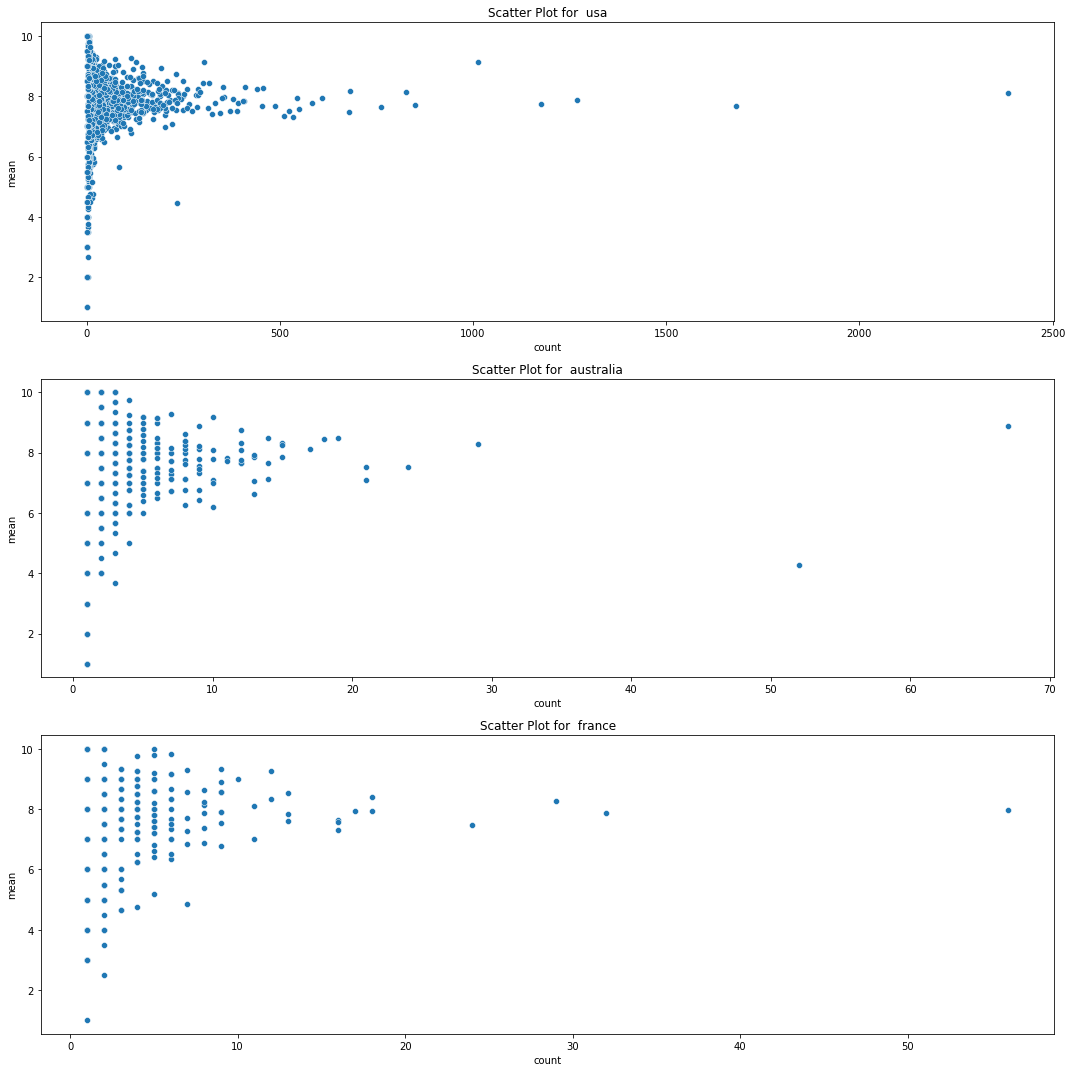

In [403]:
# Get unique user countries
unique_countries = author_country['User-Country'].unique()

# Set up subplots for each user-country
num_plots = len(unique_countries)
num_cols = 1  # Adjust number of columns based on desired layout
num_rows = (num_plots - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Plot scatter for each user-country
for i, country in enumerate(unique_countries):
    subset = author_country[author_country['User-Country'] == country]
    ax = axes[i]
    sns.scatterplot(data=subset, x='count', y='mean', ax=ax)
    ax.set_title(f'Scatter Plot for {country}')
    ax.set_xlabel('count')
    ax.set_ylabel('mean')

# Hide empty subplot(s) if present
for j in range(i + 1, num_plots):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()